In [404]:
import random
import time
import importlib
import game
importlib.reload(game)
from game import ColorableCliqueGame
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
print(tf.__version__)

colors = [(255,100,100), (100,100,255)]
env = ColorableCliqueGame(300,300,6,colors)
#env.close()

2.8.0


In [405]:
def draw(env : ColorableCliqueGame):
    imgdata = env.frame()
    plt.imshow(imgdata)
    #print(np.max(imgdata), np.min(imgdata), np.average(imgdata))
    plt.show()

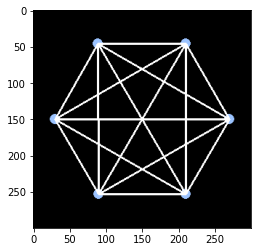

In [406]:
draw(env)

In [407]:
def checkColor(game : ColorableCliqueGame, color, nocolor, a, b, c):
    # assume (a,b) colored.
    if game.adjecencyMatrix[(a,c)] == color:
        # (a,c) also colored
        if game.adjecencyMatrix[(b,c)] == nocolor:
            # (b,c) is not colored yet.
            return 1
    elif game.adjecencyMatrix[(a,c)] == nocolor:
        # (a,c) is not colored
        if game.adjecencyMatrix[(b,c)] == color:
            # (b,c) is colored.
            return 1
    return 0

def huristics(game : ColorableCliqueGame):
    if(game.winner != -1):
        # Assume that 1 has already won, we return -(1 * 2 - 1) = -1.
        # Assume that 0 has already won, we return -(0 * 2 - 1) = 1
        score = -100 * (game.winner * 2 - 1)
        # return some value much bigger then nCr(k,3)
        return score
    # Go over all distinct triplets of vertices (a,b,c).
    # Count the number of red/blue possible triangles by adding 1 edge.
    # return the score Red - Blue.
    p0Triangles = 0
    p1Triangles = 0
    p0c = -1
    p1c = 1
    nocolor = 0
    for a in range(game.k):
        for b in range(a+1, game.k):
            for c in range(b+1, game.k):
                if game.adjecencyMatrix[(a,b)] == p0c:
                    p0Triangles += checkColor(game, p0c, nocolor, a,b,c)
                if game.adjecencyMatrix[(a,b)] == p1c:
                    p1Triangles += checkColor(game, p1c, nocolor, a,b,c)
                else:
                    # (a,b) has no color.
                    if game.adjecencyMatrix[(a,c)] == p0c and game.adjecencyMatrix[(b,c)] == p0c:
                        p0Triangles += 1
                    elif game.adjecencyMatrix[(a,c)] == p1c and game.adjecencyMatrix[(b,c)] == p1c:
                        p1Triangles += 1
    # the more triangles one can make the worse his position is.
    return p1Triangles - p0Triangles

                


In [408]:
#Searching the best move using minimax and alphabeta algorithm with negamax implementation
def alphabetaMaxDepth(cliqueGame : ColorableCliqueGame, alpha, beta, depth):
    bestscore = -99999
    if(cliqueGame.winner != -1):
        # Assume that 1 has already won, we return -(1 * 2 - 1) = -1.
        # Assume that 0 has already won, we return -(0 * 2 - 1) = 1
        score = -100 * (cliqueGame.winner * 2 - 1)
        return score
    if(depth == 0):
        return huristics(cliqueGame)
        
    curr = cliqueGame.player
    color = -(cliqueGame.player * 2 - 1)
    for move in cliqueGame.getMoves():
        cliqueGame.applyMove(move)
        # after each move the current player can only lose.
        # assume that this is the turn of player 0.
        # if after playing 0 lost. (1 won)
        # then ab(game) = -1
        # then we wish to return -1.

        # assume that this is the turn of player 1.
        # if after playing 1 lost. (0 won)
        # then ab(game) = 1
        # then we wish to return 1.

        # times 0.5, so we would prefer longer games, when we lose 100%, as the goal is to survive longer.
        if curr == cliqueGame.player:
            score = 0.975 * alphabetaMaxDepth(cliqueGame, alpha, beta, depth-1)
        else:
            score = 0.975 * alphabetaMaxDepth(cliqueGame, -beta, -alpha, depth-1)
        cliqueGame.undo()
        
        if(color * score >= beta):
            return score
        if(color * score > bestscore):
            bestscore = color * score
        if(score * color > alpha):
            alpha = score * color
    return bestscore

In [409]:
def random_move(game : ColorableCliqueGame):
    moves = game.getMoves()
    if(len(moves) > 0):
        rm = moves[int(random.random() * len(moves))]
        md = game.applyMove(rm)
        return md
    return game.applyMove(None)

In [410]:
def alphabetaMove(game : ColorableCliqueGame, depth):
    moves = game.getMoves()
    bestmove = None
    bestscore = -99999
    color = game.player * 2 - 1
    for move in moves:
        game.applyMove(move)
        score = -color * alphabetaMaxDepth(game, -99999, 99999, depth)
        game.undo()
        if score > bestscore:
            bestscore = score
            bestmove = move
    return game.applyMove(bestmove)

In [525]:
env = ColorableCliqueGame(300,300,6,colors)

[-1  1 -1  1  1 -1  1 -1 -1  1  0  1 -1 -1  1 -1]
9999


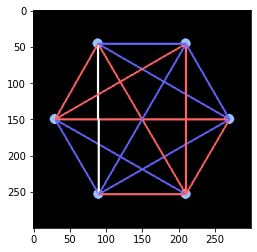

In [541]:
moves = env.getMoves()
random_move(env)
print(env.state1D())
print(alphabetaMaxDepth(env, -9999, 9999, 3))
draw(env)

In [413]:
print(alphabetaMaxDepth(env, -9999, 9999, 3))

0.0


(True, 0)
0
9999


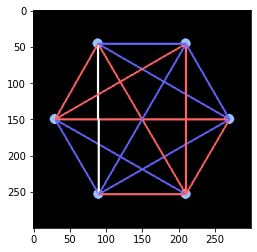

In [540]:
md = alphabetaMove(env, 3)
print(md)
print(env.winner)
print(alphabetaMaxDepth(env, -9999, 9999, 3))
draw(env)

1


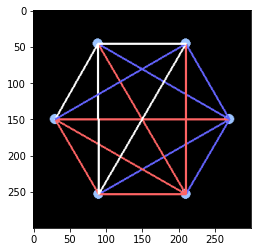

In [415]:
while(env.winner == -1):
    alphabetaMove(env,1)
print(env.winner)
draw(env)

In [416]:
#envt = ColorableCliqueGame(300,300,6,colors)
def test(test_num, random_moves, depth):
    player0Wins = 0
    player1Wins = 0
    for r in range(test_num):
        envt = ColorableCliqueGame(300,300,6,colors)
        for _ in range(random_moves):
            random_move(envt)
        #print(envt.winner)
        while(envt.winner == -1):
            #print(envt.player)
            alphabetaMove(envt, depth)
        #print(envt.winner)
        if envt.winner == 0:
            player0Wins += 1
        else:
            player1Wins += 1
        if r % 5 == 0:
            print("round ",r)
    print("player0 won :", player0Wins, "player1 won :", player1Wins)

In [448]:
test(5, 1, 99)

round  0
player0 won : 2 player1 won : 3


In [418]:
def GetAllPositions(game : ColorableCliqueGame, skip_moves, depth, save : list):
    if game.winner != -1:
        save.append([game.state1D(), alphabetaMaxDepth(game, -9999, 9999, 1)])
        return
    elif skip_moves <= 0:
        save.append([game.state1D(), alphabetaMaxDepth(game, -9999, 9999, depth)])
    
    for move in game.getMoves():
        game.applyMove(move)
        GetAllPositions(game, skip_moves-1, depth, save)
        game.undo()
        if skip_moves > 1:
            print("done...")

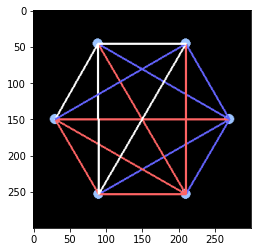

(1, 2)


C:\Users\Michael\AppData\Local\Temp\ipykernel_23828\3736199535.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.array(arr)


In [419]:
game = env
draw(game)
arr = []
GetAllPositions(game, 2, 2, arr)
arr = np.array(arr)
print(arr.shape)

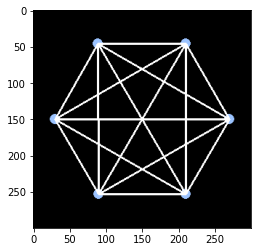

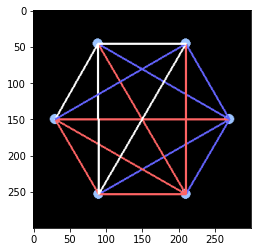

In [420]:
game = ColorableCliqueGame(300,300,6,colors)
draw(game)
draw(env)

6


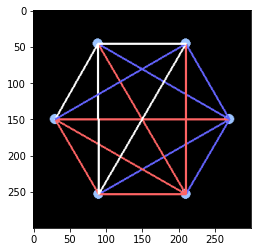

In [421]:
game = ColorableCliqueGame(300,300,6,colors)
game.loadfrom1D(env.state1D())
draw(game)

In [422]:
def nCr(n,k):
    s = n
    d = 1
    for i in range(1, k):
        s *= (n - i)
        d *= (i + 1)
    return s / d

In [423]:
nCr(nCr(7,2),3)

1330.0

In [424]:
arr = np.array(env.state1D())
np.count_nonzero(arr == 1) - np.count_nonzero(arr == -1)

0